<h1 style="text-align: center;"> Commodity & Exchange Prices </p>

##### NOTE: Plots are Commodities Data, comments & insights are copied from Google Mobility

## Table of contents
1. [Problem Domain](#Problem-Domain)
2. [Required Libraries](#Required-Libraries)
3. [Google Mobility Data](#Google-Mobililty-Data)
4. [Data Exploration](#Data-Exploration)
5. [Visualizations](#Visualizations)
6. [Resampling](#Resampling)<br>
7. [Decomposition](#Decomposition)
8. [Time Series Stationarity](#Time-Series-Stationarity)
9. [Making Time Series Stationary](#Making-Time-Series-Stationary)
10. [Autocorrelations and Partial Autocorrelations](#Autocorrelations-and-Partial-Autocorrelations)
11. [ARIMA Modeling](#ARIMA-Modeling)
12. [Conclusion](#Conclusion)

## Problem Domain

[[ go back to the top ]](#Table-of-contents)

In this notebook, time-series processing methods are applied for forecasting oil stock performance as part of the requirements of the RMDS 2021 Data Science Competition. Here, the *Google COVID-19 Community Mobility Reports* are leveraged to generate insights with time series modeling. We have just over one year of daily mobility data, measured as the percent change from established baseline values.

Google has provided access to this anonymized data in support of public health efforts to combat COVID-19. There is no historical connection of this data with oil stock performance and thus there are no currently established metrics driving performance decisions. Identifying trends in mobility and the impact of unique indicators will help our team make better decisions on how to interpret a year highly disrupted by an air-born pandemic.

## Required Libraries

[[ go back to the top ]](#Table-of-contents)

This notebook uses several Python libraries such as:

In [47]:
# Load required packages 
import datetime
from datetime import timedelta
import numpy as np
import pandas as pd

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Time-Series
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from scipy import signal
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

<a id='Commodity-Data'></a>

## Commodity & Exchange Price Data

[[ go back to the top ]](#Table-of-contents)

This dataset contains just over a year's worth of daily-frequency data from six sub-categories ("Indicators") in the United States. A total of 382 records, aggregated across county and state levels, were collected from 2020-02-15 to 2021-03-02 (YYYY-MM-DD). Each mobility indicator is measured as percent change from baseline.

From the official documentation website ([source](https://www.google.com/covid19/mobility/data_documentation.html?hl=en)):

Baseline

*    The median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020.

**Commodity & Exchange Indicators**

|Indicator|Data Type|Dataset|Region-Frequency|Description|
|---|---|---|---|---|
|**Brent Crude Oil**|*float*|Commodity Prices|Daily|Price, in USD per barrel, of Brent Complex crude oil as traded on the Intercontinental Exchange(ICE).|
|**WTI Crude Oil**|*float*|Commodity Prices|Daily|Price, in USD per barrel, of West Texas Intermediate(WTI) crude oil, as traded on the NYMSEX.|
|**Settlement Price**|*float*|Commodity & Exchange|Daily|Price of final transaction on a futures exchange for a given "trading" day.|
|**Open Interest**|*int*|Commodity & Exchange|Daily|Number of outstanding contracts(positions held) in the derivatives market. Open interest is an indicator of liquidity as each futures contract is for 100 shares.|

#### Load Data

In [48]:
# Load Data Function
def LOAD_DATA(filepath, filename):
    # Read CSV files
    if filename.endswith('.csv'):
        new_df = pd.read_csv(filepath+filename)

    # Read Excel files
    elif filename.endswith('.xlsx'):
        new_df = pd.read_excel(filepath+filename)
    print(type(new_df.index))
    if type(new_df.index) != pd.core.indexes.datetimes.DatetimeIndex:
        for col in new_df.columns:
            if col.lower().find('date') != -1:
                print(f"TIMESTAMP FOUND! '{col}'")
                print()
                new_df['date'] = pd.to_datetime(new_df[col]) # format = '%Y/%m/%d'
#                new_df.set_index('date', inplace = True)
                # If datetime col was already == 'date', no need to drop col after set_index, otherwise...
                if col != 'date':
                    new_df.drop(columns = col, inplace = True)
                
    # Try to identify the date column
    elif type(new_df.index) == pd.core.indexes.datetimes.DatetimeIndex:
        print('Index already in datetime')
        
    display(new_df.info())
    return new_df

In [68]:
filepath = '../../data/Financial_Market/'
filename = 'commodity_prices.xlsx'
df = LOAD_DATA(filepath, filename)
df

<class 'pandas.core.indexes.range.RangeIndex'>
TIMESTAMP FOUND! 'Date'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Value                   17000 non-null  float64       
 1   Sub-Sector              17000 non-null  object        
 2   Super Region            17000 non-null  object        
 3   Commodity And Exchange  17000 non-null  object        
 4   Frequency               17000 non-null  object        
 5   Source                  17000 non-null  object        
 6   Indicator               17000 non-null  object        
 7   date                    17000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 1.0+ MB


None

,Value,Sub-Sector,Super Region,Commodity And Exchange,Frequency,Source,Indicator,date
0,393834.0,COMMODITY PRICES,GLOBAL DATA,NYMEX CRUDE OIL FUTURES,DAILY,COMMODITY EXCHANGE,VOLUME,2020-08-07
1,865736.0,COMMODITY PRICES,GLOBAL DATA,NYMEX CRUDE OIL FUTURES,DAILY,COMMODITY EXCHANGE,VOLUME,2018-03-07
2,345299.0,COMMODITY PRICES,GLOBAL DATA,NYMEX CRUDE OIL FUTURES,DAILY,COMMODITY EXCHANGE,VOLUME,2021-01-25
3,353417.0,COMMODITY PRICES,GLOBAL DATA,NYMEX CRUDE OIL FUTURES,DAILY,COMMODITY EXCHANGE,VOLUME,2020-08-06
4,626407.0,COMMODITY PRICES,GLOBAL DATA,NYMEX CRUDE OIL FUTURES,DAILY,COMMODITY EXCHANGE,VOLUME,2018-03-06
...,...,...,...,...,...,...,...,...
16995,465881.0,COMMODITY PRICES,GLOBAL DATA,ICE BRENT CRUDE OIL FUTURES,DAILY,COMMODITY EXCHANGE,PREV# DAY OPEN INTEREST,2019-07-05
16996,463509.0,COMMODITY PRICES,GLOBAL DATA,ICE BRENT CRUDE OIL FUTURES,DAILY,COMMODITY EXCHANGE,PREV# DAY OPEN INTEREST,2019-07-08
16997,295191.0,COMMODITY PRICES,GLOBAL DATA,ICE BRENT CRUDE OIL FUTURES,DAILY,COMMODITY EXCHANGE,PREV# DAY OPEN INTEREST,2018-07-20
16998,444816.0,COMMODITY PRICES,GLOBAL DATA,ICE BRENT CRUDE OIL FUTURES,DAILY,COMMODITY EXCHANGE,PREV# DAY OPEN INTEREST,2019-07-09


In [70]:
df.Indicator.value_counts()

HIGH                          2000
OPEN                          2000
SETTLE                        2000
PRICE IN USD                  2000
LOW                           2000
VOLUME                        2000
CHANGE                        2000
PREV# DAY OPEN INTEREST       1000
LAST                          1000
PREVIOUS DAY OPEN INTEREST    1000
Name: Indicator, dtype: int64

In [71]:
df['Commodity And Exchange'].value_counts()

NYMEX CRUDE OIL FUTURES                 8000
ICE BRENT CRUDE OIL FUTURES             7000
WTI CRUDE OIL (DOLLARS PER BARREL)      1000
BRENT CRUDE OIL (DOLLARS PER BARREL)    1000
Name: Commodity And Exchange, dtype: int64

In [50]:
def drop_columns(dataframe):
    redund_dict = {}
    df = dataframe
    # Drop redundant columns and store redundant data more efficiently
    for col in df:
        # Identify columns with only one value repeated on every row
        value_counts = df[col].value_counts().count()
        # Reduce DataFrame if any columns contain only one value
        if value_counts == 1:
            k = col # keys
            v = df[col].value_counts().index[0] # values
            # Store redundant data in a dictionary
            redund_dict.update({k : v})
            # Drop redundant data columns
            df.drop(columns=[col], inplace = True)
    return df
drop_columns(df)

,Value,Commodity And Exchange,Indicator,date
0,393834.0,NYMEX CRUDE OIL FUTURES,VOLUME,2020-08-07
1,865736.0,NYMEX CRUDE OIL FUTURES,VOLUME,2018-03-07
2,345299.0,NYMEX CRUDE OIL FUTURES,VOLUME,2021-01-25
3,353417.0,NYMEX CRUDE OIL FUTURES,VOLUME,2020-08-06
4,626407.0,NYMEX CRUDE OIL FUTURES,VOLUME,2018-03-06
...,...,...,...,...
16995,465881.0,ICE BRENT CRUDE OIL FUTURES,PREV# DAY OPEN INTEREST,2019-07-05
16996,463509.0,ICE BRENT CRUDE OIL FUTURES,PREV# DAY OPEN INTEREST,2019-07-08
16997,295191.0,ICE BRENT CRUDE OIL FUTURES,PREV# DAY OPEN INTEREST,2018-07-20
16998,444816.0,ICE BRENT CRUDE OIL FUTURES,PREV# DAY OPEN INTEREST,2019-07-09


#### Add Calculated Columns

Some important metrics can be calculated and included in the modeling.

In [51]:
#df['new_column'] = df.column1 - df.column2
#df.head()

## Data Exploration

[[ go back to the top ]](#Table-of-contents)

In [52]:
df.describe()

,Value
count,1.700000e+04
mean,8.840723e+04
std,1.873058e+05
min,-4.032000e+01
25%,4.581000e+01
50%,5.943000e+01
75%,7.757500e+01
max,1.751861e+06


In [53]:
df.groupby(['Commodity And Exchange', 'Indicator']).describe()

Value  \
                                                                  count   
Commodity And Exchange               Indicator                            
BRENT CRUDE OIL (DOLLARS PER BARREL) PRICE IN USD                1000.0   
ICE BRENT CRUDE OIL FUTURES          CHANGE                      1000.0   
                                     HIGH                        1000.0   
                                     LOW                         1000.0   
                                     OPEN                        1000.0   
                                     PREV# DAY OPEN INTEREST     1000.0   
                                     SETTLE                      1000.0   
                                     VOLUME                      1000.0   
NYMEX CRUDE OIL FUTURES              CHANGE                      1000.0   
                                     HIGH                        1000.0   
                                     LAST                        1000.0   
                                     LOW                         1000.0   
                                     OPEN                        1000.0   
                                     PREVIOUS DAY OPEN INTEREST  1000.0   
                                     SETTLE                      1000.0   
                                     VOLUME                      1000.0   
WTI CRUDE OIL (DOLLARS PER BARREL)   PRICE IN USD                1000.0   

                                                                               \
                                                                         mean   
Commodity And Exchange               Indicator                                  
BRENT CRUDE OIL (DOLLARS PER BARREL) PRICE IN USD                    58.10948   
ICE BRENT CRUDE OIL FUTURES          CHANGE                           0.01190   
                                     HIGH                            59.56752   
                                     LOW                             57.84617   
                                     OPEN                            58.72282   
                                     PREV# DAY OPEN INTEREST     370389.01100   
                                     SETTLE                          58.72255   
                                     VOLUME                      259151.32600   
NYMEX CRUDE OIL FUTURES              CHANGE                           0.86159   
                                     HIGH                            54.00764   
                                     LAST                            53.16020   
                                     LOW                             52.22600   
                                     OPEN                            53.15355   
                                     PREVIOUS DAY OPEN INTEREST  332852.61100   
                                     SETTLE                          53.12599   
                                     VOLUME                      539917.33600   
WTI CRUDE OIL (DOLLARS PER BARREL)   PRICE IN USD                    53.06795   

                                                                                \
                                                                           std   
Commodity And Exchange               Indicator                                   
BRENT CRUDE OIL (DOLLARS PER BARREL) PRICE IN USD                    13.594313   
ICE BRENT CRUDE OIL FUTURES          CHANGE                           1.227855   
                                     HIGH                            12.789313   
                                     LOW                             12.951146   
                                     OPEN                            12.859671   
                                     PREV# DAY OPEN INTEREST     146024.439078   
                                     SETTLE                          12.897285   
                                     VOLUME                       94123.670873   
NYMEX CRUDE OIL FUTURES              CHANG

In [54]:
futures_df = df[(df['Indicator']=='PREV# DAY OPEN INTEREST') | 
   (df['Indicator']=='PREVIOUS DAY OPEN INTEREST') | 
   (df['Indicator']=='SETTLE')]
futures_df = drop_columns(futures_df)
futures_df;

In [55]:
#futures_df.groupby(['date', 'Commodity And Exchange', 'Indicator']).describe()

In [67]:
df_0

,brent_crude_oil_(dollars_per_barrel),wti_crude_oil_(dollars_per_barrel)
date,,
2017-02-23,NaN,54.48
2017-02-24,NaN,53.99
2017-02-27,NaN,54.04
2017-02-28,NaN,54.00
2017-03-01,NaN,53.82
...,...,...
2021-02-16,63.96,60.07
2021-02-17,65.02,61.09
2021-02-18,64.09,60.40


In [56]:
crude_df = drop_columns(df[df['Indicator']=='PRICE IN USD'])
crude_df

,Value,Commodity And Exchange,date
14000,44.07,BRENT CRUDE OIL (DOLLARS PER BARREL),2020-08-07
14001,65.09,BRENT CRUDE OIL (DOLLARS PER BARREL),2018-03-07
14002,55.44,BRENT CRUDE OIL (DOLLARS PER BARREL),2021-01-25
14003,45.04,BRENT CRUDE OIL (DOLLARS PER BARREL),2020-08-06
14004,65.67,BRENT CRUDE OIL (DOLLARS PER BARREL),2018-03-06
...,...,...,...
15995,67.90,WTI CRUDE OIL (DOLLARS PER BARREL),2018-07-23
15996,57.35,WTI CRUDE OIL (DOLLARS PER BARREL),2019-07-08
15997,70.31,WTI CRUDE OIL (DOLLARS PER BARREL),2018-07-20
15998,57.57,WTI CRUDE OIL (DOLLARS PER BARREL),2019-07-09


In [57]:
crude_df.groupby('Commodity And Exchange').describe()

Value                              \
                                       count      mean        std    min   
Commodity And Exchange                                                     
BRENT CRUDE OIL (DOLLARS PER BARREL)  1000.0  58.10948  13.594313   9.12   
WTI CRUDE OIL (DOLLARS PER BARREL)    1000.0  53.06795  11.946743 -36.98   

                                                                    
                                        25%     50%     75%    max  
Commodity And Exchange                                              
BRENT CRUDE OIL (DOLLARS PER BARREL)  49.96  60.720  67.460  86.07  
WTI CRUDE OIL (DOLLARS PER BARREL)    47.02  53.795  61.175  77.41

In [58]:
crude_indicators

['BRENT CRUDE OIL (DOLLARS PER BARREL)', 'WTI CRUDE OIL (DOLLARS PER BARREL)']

In [59]:
crude_df['Commodity And Exchange'].value_counts().index

Index(['BRENT CRUDE OIL (DOLLARS PER BARREL)', 'WTI CRUDE OIL (DOLLARS PER BARREL)'], dtype='object')

In [60]:
crude_df['Commodity And Exchange'].value_counts()

BRENT CRUDE OIL (DOLLARS PER BARREL)    1000
WTI CRUDE OIL (DOLLARS PER BARREL)      1000
Name: Commodity And Exchange, dtype: int64

In [61]:
crude_df['Commodity And Exchange'][:3]

14000    BRENT CRUDE OIL (DOLLARS PER BARREL)
14001    BRENT CRUDE OIL (DOLLARS PER BARREL)
14002    BRENT CRUDE OIL (DOLLARS PER BARREL)
Name: Commodity And Exchange, dtype: object

In [62]:
crude_indicators = list(crude_df['Commodity And Exchange'].value_counts().index)
count = 0
for indicator in crude_indicators:
    # Trim redundant substrings with last_char
    last_char = len(indicator)
    # Remove casing and extra white space
    #formatted_name = indicator[:last_char][count].strip().lower()
    formatted_name = indicator[:last_char].strip().lower()
    # Temporary DataFrame 'df_i' of just one indicator (DJCA, DJIA, DJTA, DJUA, etc.)
    df_i = crude_df[crude_df['Commodity And Exchange']==indicator].copy()
    #df_i['date'] = df_i['Date Value']
    df_i = df_i.groupby(['date'], as_index=True).mean()
    # Replace default 'Value' with descriptive col name
    df_i.rename(columns = {'Value': formatted_name.replace(" ", "_")}, inplace = True)
    df_i.rename(columns = {'Value': formatted_name.replace(" ", "_")}, inplace = True)
    if count == 0:
        df_0 = df_i.copy()
    else:
        df_0 = pd.concat([df_0, df_i], axis =1)
    count += 1
display(round(df_0, 2))

,brent_crude_oil_(dollars_per_barrel),wti_crude_oil_(dollars_per_barrel)
date,,
2017-02-23,NaN,54.48
2017-02-24,NaN,53.99
2017-02-27,NaN,54.04
2017-02-28,NaN,54.00
2017-03-01,NaN,53.82
...,...,...
2021-02-16,63.96,60.07
2021-02-17,65.02,61.09
2021-02-18,64.09,60.40


In [63]:
# Renname df_0
#crude_df = df_0.copy()
crude_df.isnull().sum()

Value                     0
Commodity And Exchange    0
date                      0
dtype: int64

> *Observations*
>
> Notice: We do not have to deal with missing values. However, all mobility indicators seems to have tailed off extreme values. 

## Visualizations

[[ go back to the top ]](#Table-of-contents)

In [64]:
plt.rcParams["figure.figsize"] = (20,20)
plt.style.use('seaborn')

IndexError: list index out of range

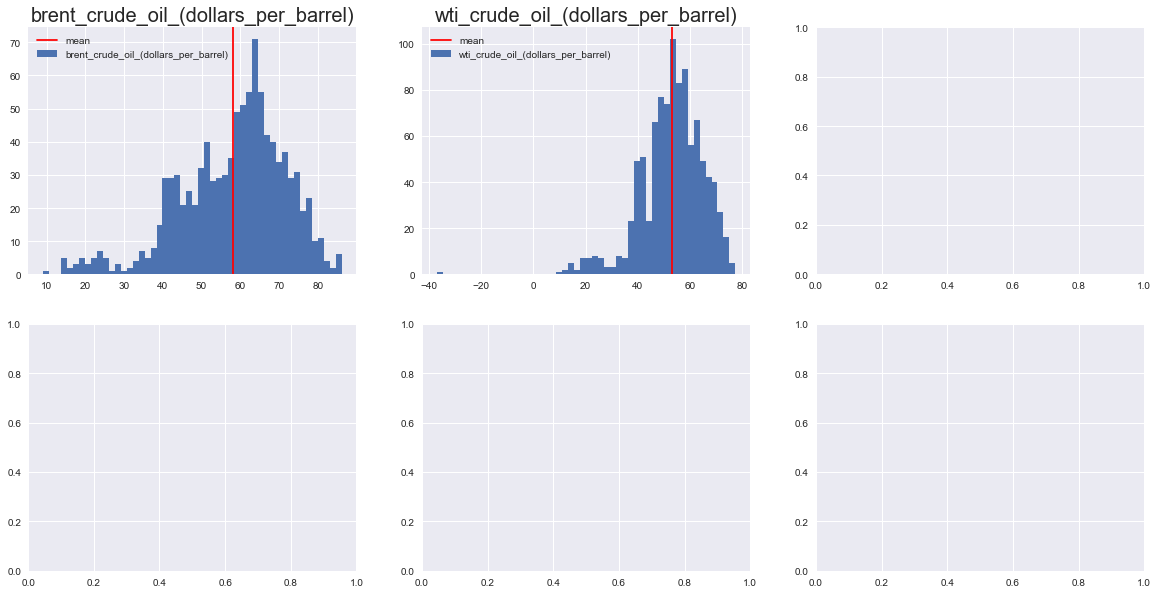

In [65]:
df = df_0.copy()
nrows, ncols, nbins = 2, 3, 50

fig, ax = plt.subplots(nrows, ncols, figsize=(20,10))
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        # To manage an odd number of subplots
        if (row == nrows-1) & (col == ncols-1):
            break
        series = df[col_list[count]]
        ax[row][col].hist(series, bins = nbins, label=series.name)
        ax[row][col].set_title(col_list[count], fontsize = label_size)
        ax[row][col].axvline(x=series.mean(), color= 'r', label = 'mean')
        ax[row][col].legend()
        count+=1
    ax[row][0].set_ylabel('Frequency', fontsize = label_size)   
ax[1][1].set_xlabel('Index Value', fontsize = label_size)
plt.suptitle('Dow Jones Indicators', y = 1.05, fontsize = label_size+5)
plt.tight_layout()

> *Observations*
>
> By plotting the histogram of mobility, we can see the characteristic distribution of each indicator.
> - Mobility trends around workplaces are predominantly negative indicating lower mobility relaitive to the baseline, and seem to center around minus 20%. There are also scattered values between -80 to -40 percent-change that require further cleaning/investigation for interpretation.
> - Mobility around places of retail, restaurants, and recreation contain many extreme low values which may pose problems in downstream analysis. 
> - Mobility trends around parks and places of residence seem to be mostly positive with two overlapping peaks in parks. 
> - Mobility around markets and drug stores seem to be centered around 0% change (in contrast to all other indicators), however, both ends seems to have scattered extreme values that may require further investigation.

### Look at a Zoomed-In Window

In [ ]:
df.info()

In [ ]:
nrows, ncols = 5, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(20,17), squeeze=False, sharex=True)

# Choose range of interest
start = '2020-02-15'
end = '2021-02-26'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        count+=1
    ax[row][0].set_ylabel('Index Value', fontsize = label_size)

plt.xticks(fontsize =label_size)
plt.tight_layout()

> *Observations*
> 
> When zoomed into the "holiday season", we can see the relationship between the mobility trends more clearly. The peaks in residential data show the private celebrations held by Americans around Thanksgiving, Christmas, and the New Year. These are the %-changes compared to a non-holiday baseline so it is expected that all other indicators would display a downward spiking mobility trend. Distinct cyclic behavior in workplace mobility is evident weekly, and appears to correspond with dips in residential mobility. This could be an indication of data-seasonality which will hinder series stationarity if left untreated.

### Look at the Entire Data

In [ ]:
#nrows, ncols = 5, 1
fig, ax = plt.subplots(nrows = 5,
                       ncols = 1,
                       figsize=(20,17), 
                       squeeze=False, # Make it all fit
                       sharex=True, # Make toggle switch
                       sharey=False) # Make User Input and toggle

# Choose range of interest
start = '2017-03-24'
end = '2021-02-26'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        count+=1
    ax[row][0].set_ylabel('Index Value', fontsize = label_size)

plt.xticks(fontsize =label_size)
plt.tight_layout()

> *Observations*
>
> A full year's worth of daily data is too condensed. Although some significant impacts such as national holidays and government enforced shutdowns can be identified, it's quite difficult to obtain actionable insights from the entire dataset. Big-picture insights can be extracted from subtle variations in the data after further processing.


## Resampling

[[ go back to the top ]](#Table-of-contents)

In [ ]:
def resample_rolling(data = df, d = 7, f = 'W'):
    # Figsize probably needs to be generalized to remove hardcoded dimensions
    fig, axs = plt.subplots(nrows = 2,
                            ncols = 1,
                            sharex= True,
                            sharey=True,
                            figsize=(14,8))
    days = d
    freq = f
    df_0 = data
    
    # Resample
    df_m = df_0.resample(freq).mean()
    # Rolling mean: Mean of a moving window across time periods, smoothing
    df_rm = df_0.rolling(days).mean()
    
    #sns.lineplot(data = df_0, ax = axs[0]);
    sns.lineplot(data = df_m, ax = axs[0], legend = False);
    
    #sns.lineplot(data = df_0, ax = axs[1]);
    sns.lineplot(data= df_rm, ax = axs[1], legend = 'full');
    
    plt.suptitle('Indicator Index Value', fontsize = label_size)
    #axs[0].xticks(fontsize =label_size), plt.yticks(fontsize =label_size)
    #axs[0].get_legend().remove()
    axs[1].legend(fontsize = 13,
                  #loc='best',
                  bbox_to_anchor=(0.5, 0.6, 0.5, 0.1)) # (x, y, width, height)
    plt.tight_layout()
    return

In [ ]:
# Default is 7-days (one week = 'W')
resample_rolling()

In [ ]:
resample_rolling(d=14, f='SM')

In [ ]:
resample_rolling(d=30, f='M');

> *Observations*
>
> We can clearly see a downward trend in parks mobility when the winter months bring less favorable outdoor weather. Currently, it can be seen that all mobility indicators are converging together slightly lower than this time last year except, notably, residential mobility trends remain steadily around 10% higher. This visualization allows us to quickly identify intervals for close inspection, aiding in an abnormality analysis.
>
> **The rest of the analysis, will focus on working with the resampled mobility data**

In [ ]:
#resample_rolling(d=90, f='Q')
#resample_rolling(d=180, f='BA')
#resample_rolling(d=365, f='Y')
freq = 'W'
df_r = df.resample(freq).mean()

The data will be subset up until 2020-08-08 where the mobility was relative stable for model building and analysis. The latter part of the data shows sharp spikes that may be result of government shutdowns, holidays, etc. which might not suitable for time-series modeling.

## Decomposition

[[ go back to the top ]](#Table-of-contents)

In [ ]:
fig, ax = plt.subplots(nrows = 5,
                       ncols = 1,
                       figsize=(20,17),
                       squeeze=False,
                       sharey = True,
                       sharex=True)

# Choose time-series subset(date range of interest)
start = '2020-02-15' # '2020-02-15' first date
end = '2021-03-02'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df_r.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        count+=1
    ax[row][0].set_ylabel('Index Value', fontsize = label_size)
plt.xticks(fontsize =label_size)
plt.tight_layout()

In [ ]:
# Decompose time-series into Trend, Seasonality and Residuals
col_list = list(df.columns)

# Choose range of interest
start = '2017-03-24'
end = '2021-02-26'

for col_i in range(len(df.columns)):
    series = df.loc[start:end, col_list[col_i]]
    decomposed = sm.tsa.seasonal_decompose(series, model = 'additive', period=7, extrapolate_trend='freq')
    plt.rc("figure", figsize=(20,10))
    fig = decomposed.plot()
    plt.grid()
    
    # Three time-series components
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    # residuals = [ Observed - (trend + seasonality) ]
    residual = decomposed.resid

> *Observations*
>
> With the data decomposed, mobility trends are noticeably short lived. A consistent downward trend is evident, for all indicators other than the increasing-residential and the steady-workplace indicators, from October 2020 through January 2021 (most recent 4 months). The seasonal aspect of the data may or may not be statistically significant, but a more conservative approach handling suggested seasonality may be apropriate. In particular, the Workplaces and Residential Mobilities may benefit from seasonal adjustment with differencing

## Time Series Stationarity


[[ go back to the top ]](#Table-of-contents)

__Check if the time series is stationarity or not:__

1. __Rolling Statistics__: Plot the moving average & moving variance, check if either vary in time.

2. __Augmented Dickey-Fuller Test:__ A statistical test for checking stationarity.
  - Null Hypothesis (H0): the time-series is NON-stationary. <br>
  - Alternate Hypothesis (H1): Reject H0, the time-series is STATIONARY.
> p-value >  threshold: FAIL to reject H0, data is NON-stationary. <br>
> p-value<= threshold: Reject H0, the data is STATIONARY.

NOTE: Most commonly: Threshold = 0.05

Reference: https://otexts.com/fpp2/stationarity.html

In [ ]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    roll_mean = timeseries.rolling(window=10).mean()
    roll_std = timeseries.rolling(window=10).std()
    #Plot rolling statistics:
    plt.figure(figsize = (20,5))
    obs = plt.plot(timeseries, color='blue', label= f'Indicator: {col_list[col_i]}')
    rmean = plt.plot(roll_mean, color='red', label='Rolling-Mean')
    rstd = plt.plot(roll_std, color='black', label = 'Rolling-Stdev')
    # Formatting
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Index Value')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print (f'Dickey-Fuller Test Results: {col_list[col_i]}')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','# Observations Used'])
    for key, val in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = val
    print (dfoutput)
    print()

In [ ]:
col_list = list(work_diff.columns)
for col_i in range(len(col_list)):
    test_stationarity(work_diff[col_list[col_i]])

In [ ]:
col_list = list(df.columns)
for col_i in range(len(list(df.columns))):
    test_stationarity(df[col_list[col_i]])

> **Insights**
>
> Without further processing, the trends in retail, grocery, transit, and parks mobilities are not stationary. This is identified by the observable trends in rolling 10-day means(red) and acceptance of the "Dickey-Fuller H0's" that the mobility indicators are not stationary(p-value > 0.05). In particular, H0 is rejected for mobility trends around workplaces and places of residence (p-value < 0.05). Additionally, each mobility indicator seems to have a relatively steady variance indicating that the time-series interactions between trend, seasonality, and residual are additive.

## Making Time Series Stationary

### Differencing

[[ go back to the top ]](#Table-of-contents)

In [ ]:
# Create a differenced series
def difference(dataset, interval = 1):
    difference = dataset-dataset.shift(interval)
        
    return difference.dropna(inplace= False)

In [ ]:
# Seasonal adjustment with differencing
X = df.workplaces.copy()
diff = []
days_in_week = 7
for i in range(days_in_week, len(X)):
    # Differencing by one-week (7 days)
    value = X[i] - X[i - days_in_week]
    items = (str(X.index[i]), value)
    diff.append(items)
work_diff = pd.DataFrame(diff, columns = ['date', 'workplaces_season7'])
work_diff['date'] = pd.to_datetime(work_diff['date'])
work_diff.set_index('date', inplace = True)
plt.plot(work_diff)
plt.title('Workplaces Mobility: 7-Day Seasonally Adjusted differencing')
plt.show()

#### DJTA Differencing

In [ ]:
df_differenced = difference(df[['dow_jones_transportation_average']])
plt.figure(figsize=(20,5))
plt.plot(df_differenced)
plt.grid()
test_stationarity(df_differenced)

In [ ]:
# Decompose time-series into Trend, Seasonality and Residuals
col_list = list(df_differenced.columns)
for col_i in range(len(df_differenced.columns)):
    decomposed = sm.tsa.seasonal_decompose(df_differenced[col_list[col_i]],
                                           model = 'additive',
                                           period = 5,
                                           extrapolate_trend='freq')
    plt.rc("figure", figsize=(20,10))
    fig = decomposed.plot()
    plt.grid()
    
    # Three time-series components
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    # residuals = [ Observed - (trend + seasonality) ]
    residual = decomposed.resid

## Autocorrelations and Partial Autocorrelations

[[ go back to the top ]](#Table-of-contents)

In [ ]:
## Calculate the ACF and PACF for the flow series up to 20 lags
#df_sub = df[['workplaces']]
# acf_20 = acf(df_sub, nlags=20)
# pacf_20 = pacf(df_sub, nlags=20)
def ACF_PACF_diff(timeseries_df):
    # Draw Plot
    fig, axs = plt.subplots(nrows = 2,
                            ncols = 2,
                            figsize=(20,10),
                            dpi= 100,
                            sharex = True,
                            sharey = True)

    ts = timeseries_df
    plot_acf(ts, lags=20, ax=axs[0][0])
    plot_pacf(ts, lags=20, ax=axs[0][1])

    ts_diff = difference(ts)
    plot_acf(ts_diff, lags=20, ax=axs[1][0])
    plot_pacf(ts_diff, lags=20, ax=axs[1][1])
    axs[1][0].title.set_text('Autocorrelation-Differenced')
    axs[1][1].title.set_text('Partial Autocorrelation-Differenced')
    plt.suptitle(f'{ts.columns[0]} Mobility'.upper(), fontsize = 20)
    return
    #plt.show()

In [ ]:
ACF_PACF_diff(df[['dow_jones_transportation_average']])

> *Observations*
>
> Large-positive values for small lags suggest evidence of a trend and a "weekly seasonality" is obviously present in both the non-differenced and the differenced data.

In [ ]:
ACF_PACF_diff(df_differenced)

> *Observations*
>
> For "Workplace Mobility", the Seasonally-adjusted series' autocorrelations are significant for several lags. The PACF plot has significant spikes only at Lags-1, 7 & 8, therefore all the higher-order autocorrelations are effectively explained by the Lag-1 and weekly lags. We will add these(L-1, L-7, L-8) autocorrelation terms to the forecasting equation.<br>
>* SARIMAX: Include L-1 ( p=[1], d=1, q ) and L-7 (P, D=0, Q, s=7)
>* Maybe include L-2 ( p=[2], d=1, q ) or both L-1 and L-2 ( p=2, d=1, q )
>* Try q, Q =[0,1,2]

### ARIMA Modeling

[[ go back to the top ]](#Table-of-contents)

In [ ]:
df_differenced

In [ ]:
fig, ax = plt.subplots(nrows = 3,
                       ncols = 1,
                       figsize=(20,10), 
                       sharex = True)

df_sub = df[['dow_jones_transportation_average']]

# Element-wise subtraction w/ a Series, for set_title("RSS")
df_diff = df_differenced.dow_jones_transportation_average

fsize = 15
p = 5; d = 1; q = 1

for nax in range(3):
    if nax == 0:
        # AR Model, choose "p" (p, d = 1, q = 0)
        model = ARIMA(df_sub, order=(p,d,0))
        results_AR = model.fit(disp=-1)
        ax[nax].plot(results_AR.fittedvalues, label = f'AR({p}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'AR({p}) Model - RSS: %.4f'%sum((results_AR.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    elif nax == 1:
        # MA Model, choose "q" (p = 0, d = 1, q)
        model = ARIMA(df_sub, order=(0,d,q))
        results_MA = model.fit(disp=-1)
        ax[nax].plot(results_MA.fittedvalues, label = f'MA({q}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'MA({q}) Model - RSS: %.4f'%sum((results_MA.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    elif nax == 2:
        # ARIMA model, choose "p" & "q" (p, d, q)
        model = ARIMA(df_sub, order=(p,d,q))
        results_ARIMA = model.fit(disp=-1)
        ax[nax].plot(results_ARIMA.fittedvalues, label = f'ARIMA({p},{d},{q}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'ARIMA({p},{d},{q}) Model - RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    ax[nax].plot(df_diff, label = 'Original')    
    ax[nax].legend()
    #ax[nax].set_xlabel('Timestamp')
    ax[nax].set_ylabel('Index Value', fontsize = fsize)
plt.suptitle('Dow Jones Transportation Average', y=1.05, fontsize=20)    
plt.tight_layout()

> *Insights*
>
>

## Conclusion

[[ go back to the top ]](#Table-of-contents)

In [ ]:
# save DataFrame for modeling
df.to_csv(r'../../data/Financial_Market/dow_jones.csv', index = True)

df

In [ ]:
df